In [1]:
import sys
sys.path.append('../')

import seaborn as sns
from data_model import Individual
from sys_utils import load_model

checkpoint_path = '../checkpoints_dev'

individuals = load_model(
        Individual, name=checkpoint_path + "/individuals.jsonl"
    )

from tqdm import tqdm

all_page = []
for ind in tqdm(individuals):
    try:
        for page in ind.wikipedia_pages:
            res = page.dict()
            res['wikidata_id'] = ind.id.wikidata_id
            all_page.append(res)
    except:
        pass
    
template = 'simple_white'

import pandas as pd

df_proxies_all = pd.DataFrame(all_page)
df_proxies = df_proxies_all[~df_proxies_all['language'].str.contains('commons.wikimedia')]

In [7]:
#individuals[0].wikipedia_pages

100%|████████████████████████████████| 225636/225636 [00:14<00:00, 15760.85it/s]


In [10]:

df_proxies = df_proxies.drop(['url', 'author', 'created_at', 'author_editcount'], axis=1)
df_proxies = df_proxies.fillna(0)

In [11]:
df_proxies_group = df_proxies.groupby('wikidata_id').sum()

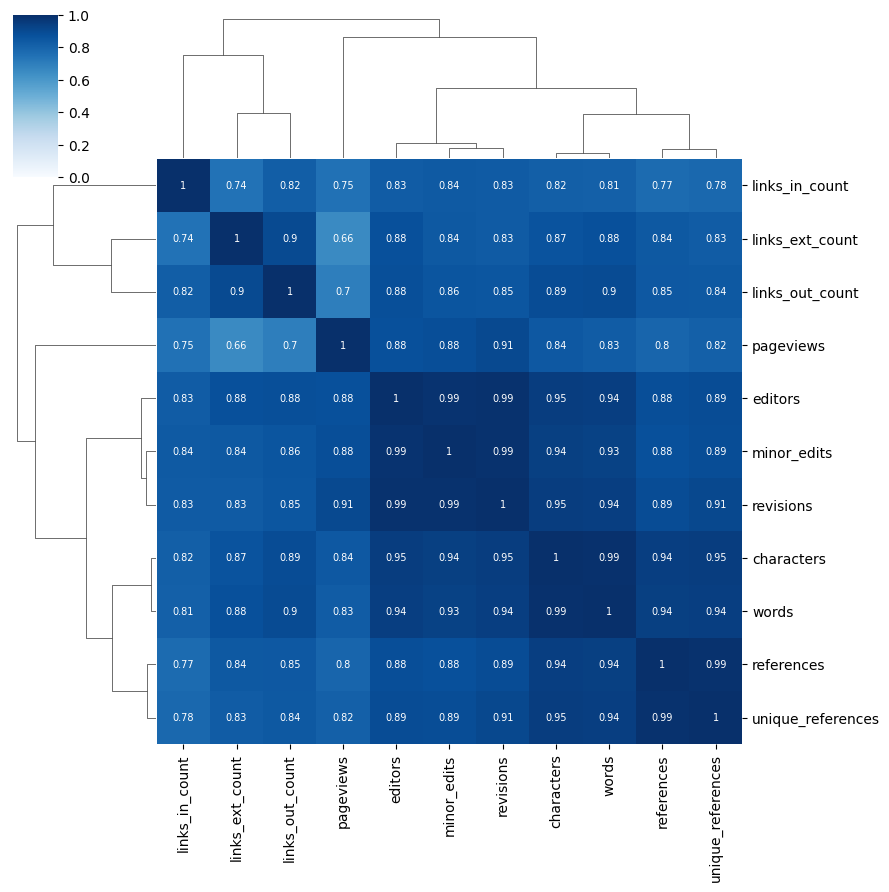

In [12]:
fig = sns.clustermap(df_proxies_group.corr(), method="complete", cmap='Blues', annot=True, 
               annot_kws={"size": 7}, vmin=0, vmax=1, figsize=(9,9));


fig.savefig("save_figures/proxies_correlation.png", dpi = 600)

In [13]:
# get the yearly adds

In [14]:
individuals_filtered = [x for x in individuals if x.regions != None]
individuals_filtered = [x for x in individuals_filtered if x.identifiers != None]

df_individuals = [
    {
        "wikidata_id": x.id.wikidata_id,
        "region_code": x.regions,
        "cultural_score":x.cultural_score,
         "year": x.impact_years,
    }
    for x in individuals_filtered
]


from data_model_region import Region
df = pd.DataFrame(df_individuals)
df = df.explode('region_code')

regions = load_model(
    Region, name=checkpoint_path + "/regions.jsonl"
)

df_regions = [
        {
            "region_code": x.code,
            "region_name": x.name,
        }
        for x in regions
    ]

df_regions = pd.DataFrame(df_regions)
df = pd.merge(df, df_regions, on = 'region_code')


In [28]:


df_created_at = df_proxies_all[['language', 'wikidata_id', 'created_at']].dropna()
df_created_at = df_created_at.drop_duplicates()
df_created_at['creation_year'] = df_created_at['created_at'].apply(lambda x : x[:4])
df_created_at = df_created_at.drop('created_at', axis=1)

df = pd.merge(df, df_created_at, on = 'wikidata_id')

In [31]:
df_wiki = df.drop('creation_year', axis=1)

In [32]:
df_wiki

,wikidata_id,region_code,cultural_score,year,region_name,language
0,Q6121397,re_western_europe,0.100247,"(1850, 1900)",Western Europe,es
1,Q6121397,re_spain,0.100247,"(1850, 1900)",Spain,es
2,Q861742,re_western_europe,0.101501,"(1700, 1750)",Western Europe,en
3,Q861742,re_western_europe,0.101501,"(1700, 1750)",Western Europe,es
4,Q861742,re_western_europe,0.101501,"(1700, 1750)",Western Europe,fr
...,...,...,...,...,...,...
2208546,Q495259,re_korea,0.104791,"(1690, 1740)",Korea,tr
2208547,Q495259,re_korea,0.104791,"(1690, 1740)",Korea,zh
2208548,Q16180175,re_korea,0.101152,"(1440, 1490)",Korea,ko
2208549,Q12624212,re_korea,0.100188,"(1690, 1740)",Korea,ko


In [67]:
region = ['France']
wikis = ['en', 'fr', 'ja', 'zh']

In [68]:
import numpy as np

In [69]:
df_filtered = df_wiki[(df_wiki['language'].isin(wikis)) & (df_wiki['region_name'].isin(region))]
df_filtered['decade'] = df_filtered['year'].apply(
        lambda x: [year for year in range(int(x[0]), int(x[1]) + 10, 10)]
    )
df_filtered = df_filtered.explode('decade')
df_filtered = df_filtered.groupby(['language', 'decade'])['cultural_score'].sum().reset_index()
df_filtered = df_filtered[(df_filtered['decade']>=1000)&(df_filtered['decade']<=1850)]
df_filtered['cultural_score'] = np.log(1 + df_filtered['cultural_score'])
wiki_code = pd.read_csv('manual_data/Wikipedia_language - code.csv')
wiki_code = wiki_code.rename(columns = {'code':'language'})
df_filtered = pd.merge(df_filtered, wiki_code, on = 'language')
df_filtered = df_filtered.rename(columns = {'english_language_name':'wikipedia'})

/var/folders/lx/9b13r6ln63jb54_3xlf9b_380000gn/T/ipykernel_25900/4034611567.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [70]:
fig = px.line(df_filtered, x = 'decade', 
              y = 'cultural_score', 
              color = 'wikipedia', 
              width = 1000, 
              height = 600, 
              title = 'France Cultural Score',
             template = 'plotly_white')

fig.update_xaxes(showgrid=False, showticklabels=True, zeroline=False)
fig.update_yaxes(showgrid=False, showticklabels=True, zeroline=False)
fig.update_layout(title_font=dict(size=20))
fig.update_layout(
    xaxis_title="",
    yaxis_title='Cultural Score')
import plotly
plotly.offline.plot(fig)


'temp-plot.html'

In [71]:

#fig.write_image(f"save_figures/identifiers_line.png", scale=7)

In [18]:
import plotly.express as px

/var/folders/lx/9b13r6ln63jb54_3xlf9b_380000gn/T/ipykernel_25900/3352572912.py:9: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



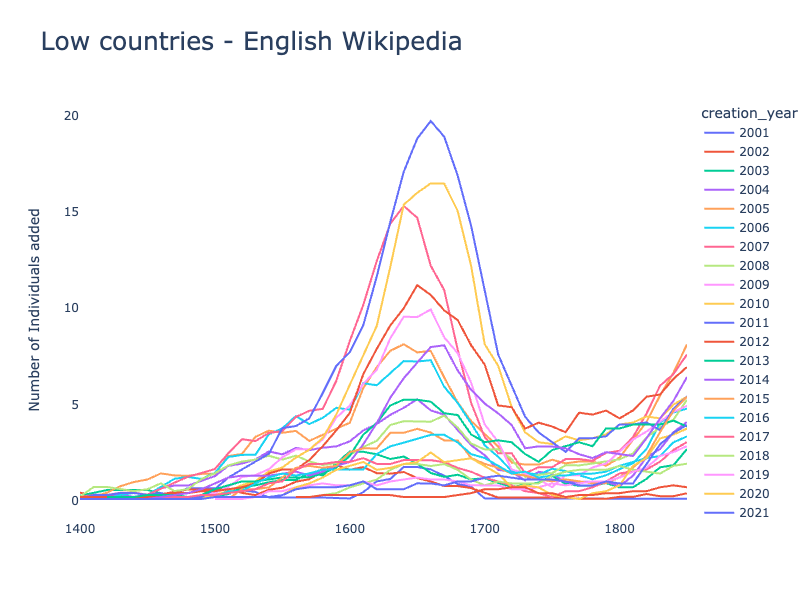

In [25]:
region_name = 'Low countries'
wiki_language = 'en'

#wiki_language = 'en'
new_df = df[df['language']==wiki_language].reset_index(drop=True)


df_country = new_df[new_df['region_name']==region_name]
df_country["year"] = df_country["year"].apply(
        lambda x: [year for year in range(int(x[0]), int(x[1]) + 10, 10)]
    )

df_country = df_country.explode('year').reset_index(drop=True)


df_fig = df_country.groupby(['creation_year', 'year'])['cultural_score'].sum().reset_index()
#df_fig = df_fig[(df_fig['year']<= max_year)&(df_fig['year']>= min_year)]
df_fig = df_fig[(df_fig['year']<= 1850)]
df_fig = df_fig[(df_fig['year']>= 1400)]

fig = px.line(df_fig, 
              x = 'year', 
              y = 'cultural_score', 
              color = 'creation_year', 
              width = 1000, 
              height = 600, 
              template = 'plotly_white',
              title = region_name + ' - ' + 'English Wikipedia')
#df_fig = df_fig.rename(columns = {'wikidata_id':'Number of Individuals'})

fig.update_xaxes(showgrid=False, showticklabels=True, zeroline=False)
fig.update_yaxes(showgrid=False, showticklabels=True, zeroline=False)
fig.update_layout(title_font=dict(size=25))

#fig.write_image(f"save_figures/creation_date_{region_name}_{wiki_language}_cultural_score.png", scale=5)
fig.update_layout(
    xaxis_title="",
    yaxis_title='Number of Individuals added')

In [ ]:

corr_test = df_country.groupby(['creation_year', 'year'])['wikidata_id'].count().reset_index()

In [ ]:
df_corr = corr_test.pivot(index = 'year', columns = 'creation_year', values = 'wikidata_id')
df_corr = df_corr.fillna(0)


fig = sns.clustermap(df_corr.corr(), method="complete", cmap='Reds', annot=True, 
               annot_kws={"size": 7}, vmin=0, vmax=1, figsize=(9,9));


fig.savefig("save_figures/creation_date_correlation_en_greek_world.png", dpi = 600)

In [ ]:
# top 10 languages correlation on cultural index

In [ ]:
wiki_ref_lang = pd.read_csv('manual_data/Wikipedia_language - code.csv')
wiki_ref_lang = wiki_ref_lang.rename(columns = {'code':'language'})

df_proxies_all_clean = pd.merge(df_proxies_all, wiki_ref_lang, on = 'language', how = 'outer')

In [ ]:
count_contributions = df_proxies_all_clean[['url', 'english_language_name', 'unique_references']].dropna()
count_contributions = count_contributions.groupby('english_language_name')['unique_references'].mean().reset_index()
count_contributions = count_contributions.sort_values('unique_references', ascending=False).reset_index(drop=True)
#count_contributions = count_contributions.head(20)
count_contributions['unique_references'] = round(count_contributions['unique_references'], 0)


In [ ]:
count_contributions['unique_references'].head(20).mean()

In [ ]:


fig = px.bar(count_contributions, x = 'english_language_name', y = 'unique_references',  text_auto=True)
fig.update_xaxes(showgrid=False, showticklabels=True, zeroline=False)
fig.update_yaxes(showgrid=False, showticklabels=True, zeroline=False)

In [ ]:


fig.write_image(f"save_figures/mean_unique_editors.png", scale=7)

In [ ]:
#df_proxies_all[].to_clipboard(index=False)

In [ ]:
df_proxies_all_non_english = df_proxies_all[df_proxies_all['language']!= 'en']
df_proxies_all_non_english['english_language_name'] = 'Non-English'

In [ ]:
len(set(df_proxies_all.wikidata_id))

In [ ]:
final_lang = pd.concat([df_proxies_all, df_proxies_all_non_english])

In [ ]:
countries = ['English', 'Non-English']

In [ ]:
df_inter = final_lang[final_lang['english_language_name'].isin(countries)]
df_inter = df_inter[['english_language_name', 'wikidata_id']].drop_duplicates().reset_index(drop=True)

In [ ]:
len(set(df_inter.wikidata_id))

In [ ]:
def intersection(lst1, lst2):
    lst3 = [value for value in lst1 if value in lst2]
    return lst3

In [ ]:
lst1 = set(list(df_inter[df_inter['english_language_name']==countries[0]]['wikidata_id']))
lst2 = set(list(df_inter[df_inter['english_language_name']==countries[1]]['wikidata_id']))
#lst3 = set(list(df_inter[df_inter['english_language_name']==countries[2]]['wikidata_id']))

In [ ]:
from matplotlib_venn import venn3, venn3_circles

In [ ]:
fig = venn2([lst1, lst2], countries)

In [ ]:
type(fig)

In [ ]:
df_language = df.drop(['creation_year'], axis=1)

In [ ]:
df_language["year"] = df_language["year"].apply(
                lambda x: [year for year in range(int(x[0]), int(x[1]) + 10, 10)]
            )

In [ ]:
df_language = df_language.explode('year')

In [ ]:
top_languages = df_language[['wikidata_id', 'language']].drop_duplicates()['language'].value_counts().reset_index().head(10)

In [ ]:
top_languages = list(top_languages['index'])

In [ ]:
df_language_corr = df_language.groupby(['language', 'region_code', 'year'])['wikidata_id'].count().reset_index()

In [ ]:
all_regions = []
for region_code in tqdm(list(set(df_language_corr.region_code))):

    df_inter = df_language_corr[df_language_corr['region_code']==region_code]
    df_fin = df_inter.pivot(index = 'year', columns = 'language', values = 'wikidata_id')
    df_fin = df_fin.fillna(0)
    df_fin = df_fin.corr()
    df_fin.index.name = 'language_1'
    df_fin = df_fin.unstack().reset_index()
    df_fin = df_fin[df_fin[0] != 1].reset_index(drop=True)
    df_fin['region_code'] = region_code
    all_regions.append(df_fin)

In [ ]:
df_corr_wiki = pd.concat([x for x in all_regions])
df_corr_wiki = df_corr_wiki.rename(columns = {0:"correlation"})

In [ ]:
fig = px.histogram(df_corr_wiki, x = 'correlation')
# Add linear density trace
fig.update_xaxes(showgrid=False, showticklabels=True, zeroline=False)
fig.update_yaxes(showgrid=False, showticklabels=True, zeroline=False)

In [ ]:
fig.write_image(f"save_figures/distrribution_pairwise_wiki_correlation_all_regions.png", scale=7)